In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import pennylane as qml
import tensorflow as tf
from tensorflow import keras
from eqmarl import *
import numpy as np
import gymnasium as gym
from PIL import Image
from pathlib import Path

In [109]:
def render_episode_as_gif_frames(env_name, actor, max_steps):
    env = gym.make(env_name, render_mode='rgb_array')
    
    state, _ = env.reset()
    
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    
    for i in range(1, max_steps+1):
        state = tf.expand_dims(state, 0)
        action_probs = actor(state)
        action = np.argmax(np.squeeze(action_probs))
        
        state, reward, done, _, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        
        screen = env.render()
        images.append(Image.fromarray(screen))
        
        if done:
            break

    return images

# def render_trajectory_as_gif_frames(env_name: str, trajectory: list[dict]):
#     env = gym.make(env_name, render_mode='rgb_array')
#     for i, t in enumerate(trajectory):
        

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )
    
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

In [110]:
env = gym.make('FrozenLake-v1', map_name='8x8')
env.observation_space, env.action_space

(Discrete(64), Discrete(4))

In [111]:
env = gym.make('CartPole-v1')
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [112]:
env = gym.make('CartPole-v1')
n_actions = 2 # because `env.action_space.n == 2`
n_wires = 4 # because `env.observation_space.shape == (4,)`
input_shape = (4,) # Shape of model input, which should match the observation vector shape `env.observation_space.shape == (4,)`

# Create the circuit for the specific environment above.
observables = lambda wires: AlternatingWeightedObservables(
    TensorObservables(
        PauliObservables(
            wires=wires,
            op=qml.PauliZ,
        )
    ),
    n_reps=n_actions,
)
circuit = AgentCircuit(
    wires=n_wires,
    n_layers=3,
    observables=observables,
)

In [113]:
### Visualize the circuit.
weight_shapes = circuit.weight_shapes
weights = {
    k: np.random.uniform(low=0., high=np.pi, size=s)
    for k, s in weight_shapes.items()
}
# shape_var, shape_enc = circuit.shape
# weights_var = np.random.uniform(low=0., high=np.pi, size=shape_var)
# weights_enc = np.random.uniform(low=0., high=np.pi, size=shape_enc)
print(qml.draw(circuit, wire_order=circuit.wires)(**weights))

0: ─╭VariationalEncodingPQC─┤ ╭<𝓗(1.00)> ╭<𝓗(-1.00)>
1: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
2: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
3: ─╰VariationalEncodingPQC─┤ ╰<𝓗(1.00)> ╰<𝓗(-1.00)>


In [114]:
# Turn circuit into keras layer.
qlayer = circuit.get_keras_layer()

In [115]:
# inp = keras.Input(shape=env.observation_space.shape) # Environment state shape is 16-dimensional.
# x = inp
# # x = keras.layers.Dense(units=qlayer.input_shape[-1])(x) # Dense layer to ensure the shape matches that of the quantum circuit.
# x = qlayer(x)
# # x = keras.layers.Softmax()(x)
# model = keras.Model(inputs=inp, outputs=x)



model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(units=qlayer.input_shape[-1]), # Dense layer to ensure the shape matches that of the quantum circuit.
    qlayer,
    keras.layers.Softmax(),
    # keras.layers.Lambda(lambda x: tf.argmax(x, axis=-1)),
    # keras.layers.Reshape(target_shape=(1,)),
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 keras_layer_6 (KerasLayer)  (None, 2)                 60        
                                                                 
 softmax_18 (Softmax)        (None, 2)                 0         
                                                                 
Total params: 80 (320.00 Byte)
Trainable params: 80 (320.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [116]:
trajectory = []
state, _ = env.reset()
state_shape = state.shape
for t in range(100):
    state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
    res = model(state)
    action = np.asarray(tf.argmax(res, axis=-1))[0]
    next_state, reward, done, _, _ = env.step(action)
    next_state = np.asarray(next_state).reshape(state.shape)
    
    traj = dict(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done,
    )
    trajectory.append(traj)
    state = next_state
    print(traj)
    
    if done:
        break

1
{'state': array([[-0.01996721, -0.03476997,  0.00652758,  0.0253366 ]],
      dtype=float32), 'action': 1, 'reward': 1.0, 'next_state': array([[-0.02066261,  0.16025777,  0.00703431, -0.26527968]],
      dtype=float32), 'done': False}


/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


1
{'state': array([[-0.02066261,  0.16025777,  0.00703431, -0.26527968]],
      dtype=float32), 'action': 1, 'reward': 1.0, 'next_state': array([[-0.01745745,  0.3552786 ,  0.00172872, -0.55573565]],
      dtype=float32), 'done': False}
1
{'state': array([[-0.01745745,  0.3552786 ,  0.00172872, -0.55573565]],
      dtype=float32), 'action': 1, 'reward': 1.0, 'next_state': array([[-0.01035188,  0.55037624, -0.00938599, -0.8478734 ]],
      dtype=float32), 'done': False}
1
{'state': array([[-0.01035188,  0.55037624, -0.00938599, -0.8478734 ]],
      dtype=float32), 'action': 1, 'reward': 1.0, 'next_state': array([[ 6.5564777e-04,  7.4562496e-01, -2.6343461e-02, -1.1434931e+00]],
      dtype=float32), 'done': False}
1
{'state': array([[ 6.5564777e-04,  7.4562496e-01, -2.6343461e-02, -1.1434931e+00]],
      dtype=float32), 'action': 1, 'reward': 1.0, 'next_state': array([[ 0.01556815,  0.94108105, -0.04921332, -1.4443195 ]],
      dtype=float32), 'done': False}
1
{'state': array([[ 0.01556

rendering 14 frames to GIF ./images/gym_CartPole.gif


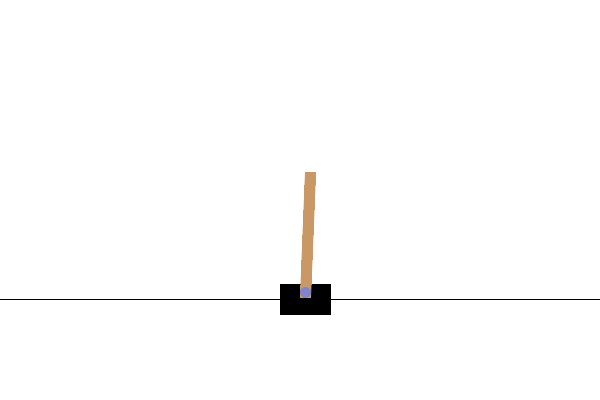

In [122]:
gif_path = './images/gym_CartPole.gif'
frames = render_episode_as_gif_frames('CartPole-v1', model, 100)
print(f"rendering {len(frames)} frames to GIF {gif_path}")
save_frames_as_gif(frames, gif_path)
display_gif(gif_path)

In [94]:
s, _ = env.reset()
s = np.asarray(s)[None, :]
s.shape

(1, 4)

In [93]:
s, _ = env.reset()
# s = np.asarray(s).reshape(1, 4)
# s = np.asarray([s, s])
s = np.asarray(s)[None, :].repeat(5, axis=0)
model(s)
# s.shape

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.35855764, 0.6414424 ],
       [0.35855764, 0.6414424 ],
       [0.35855764, 0.6414424 ],
       [0.35855764, 0.6414424 ],
       [0.3585576 , 0.6414424 ]], dtype=float32)>

In [88]:
keras.layers.Lambda(lambda x: tf.argmax(x, axis=-1))(keras.layers.Softmax()(qlayer(s)))

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 1, 1])>

In [10]:
len(model.layers[1].get_weights())

2

In [ ]:
qml.qnn.KerasLayer.compute_output_shape()

In [11]:
qlayer.get_weights()

[array([[[2.779676  , 1.8895996 , 0.3551851 ],
         [0.4370763 , 1.6767436 , 2.786039  ],
         [3.117293  , 1.2660701 , 2.8539016 ],
         [0.19082893, 2.2564154 , 1.4916829 ]],
 
        [[1.9537493 , 0.12877125, 1.4064158 ],
         [1.8604503 , 1.483519  , 3.070688  ],
         [1.6275402 , 0.23737828, 0.03792521],
         [0.8676418 , 2.450834  , 0.16465613]],
 
        [[0.8643993 , 2.9948845 , 0.01621765],
         [1.7288653 , 0.16435504, 0.9930717 ],
         [1.9744045 , 0.12962961, 0.2147577 ],
         [2.6725533 , 3.075475  , 1.7726152 ]],
 
        [[0.39616477, 1.7307558 , 3.0141573 ],
         [1.1535667 , 0.30248934, 0.68736684],
         [0.3913183 , 2.447158  , 2.693568  ],
         [0.11174691, 1.7640971 , 2.4550498 ]]], dtype=float32),
 array([[[1.],
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         [1.]]], dtype=float32)]

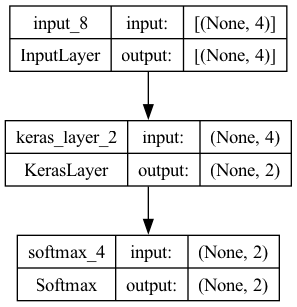

In [30]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [48]:
model([np.ones(shape=(3, 16,))])

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.31638435, 0.18472214, 0.31093252, 0.18796101],
       [0.31638435, 0.18472214, 0.31093252, 0.18796101],
       [0.31638438, 0.18472214, 0.31093255, 0.18796103]], dtype=float32)>

In [29]:
import inspect
from typing import TypedDict

# class KwargsDict(TypedDict):
#     inputs: Any

# def func(**{inputs:}: KwargsDict):
#     pass

# inspect.signature(func).parameters

inspect.signature(AgentCircuit.__call__).parameters

mappingproxy({'self': <Parameter "self">,
              'weights_var': <Parameter "weights_var">,
              'weights_enc': <Parameter "weights_enc">,
              'inputs': <Parameter "inputs=None">})